# Legendre Usage Examples

This notebook is essentially an abbreviated clone of the [Chebyshev usage examples](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev.ipynb), but using the Legendre-based differentiation function instead.

In [1]:
import sys; sys.path.append('../specderiv') # so I can import specderiv code from a neighboring working directory
from specderiv import legendre_deriv
import numpy as np
from matplotlib import pyplot
import time

We'll want equispaced points, although we can use whatever we want.

In [2]:
N = 20
x_n = np.linspace(-1, 1, N+1, endpoint=True)
x = np.linspace(-1, 1, 100)

## Derivatives in 1D

The most basic thing this package accomplishes is taking derivatives. It's useful to look at what it calculates in 1D against a known answer. Here I'm testing against the function $e^x \sin(5 x)$, which has some interesting wiggles on $[-1, 1]$, is easy to differentiate analytically, and *isn't* periodic.

I've gone all the way up to the $6^{th}$ derivative, because it's beyond what I calculated by hand.

execution ms: 4.41288948059082


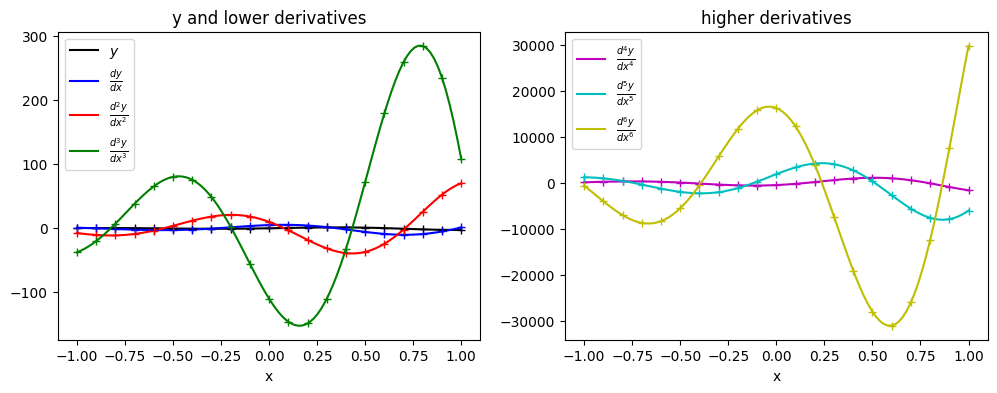

In [3]:
# You can evaluate these with WolframAlpha or by hand.
y = lambda x: np.exp(x) * np.sin(5*x)
dy = lambda x: np.exp(x) * (5*np.cos(5*x) + np.sin(5*x))
d2y = lambda x: 2*np.exp(x) * (5*np.cos(5*x) - 12*np.sin(5*x))
d3y = lambda x: -2*np.exp(x) * (37*np.sin(5*x) + 55*np.cos(5*x))
d4y = lambda x: 4*np.exp(x) * (119*np.sin(5*x) - 120*np.cos(5*x))
d5y = lambda x: 4*np.exp(x) * (719*np.sin(5*x) + 475*np.cos(5*x))
d6y = lambda x: 8*np.exp(x) * (2035*np.cos(5*x) - 828*np.sin(5*x))

# I'm breaking these apart across two subplots, because the scale gets enormous
# for higher derivatives and obscures what's happening for the lower ones.
fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(x, y(x), 'k', label="$y$")
axes[0].plot(x, dy(x), 'b', label=r"$\frac{dy}{dx}$")
axes[0].plot(x, d2y(x), 'r', label=r"$\frac{d^2y}{dx^2}$")
axes[0].plot(x, d3y(x), 'g', label=r"$\frac{d^3y}{dx^3}$")
axes[0].set_title("y and lower derivatives")
axes[0].set_xlabel('x')
axes[0].legend()
axes[1].plot(x, d4y(x), 'm', label=r"$\frac{d^4y}{dx^4}$")
axes[1].plot(x, d5y(x), 'c', label=r"$\frac{d^5y}{dx^5}$")
axes[1].plot(x, d6y(x), 'y', label=r"$\frac{d^6y}{dx^6}$")
axes[1].set_title("higher derivatives")
axes[1].set_xlabel('x')
axes[1].legend()

y_n = np.exp(x_n) * np.sin(5*x_n)
before = time.time()
dy_n = legendre_deriv(y_n, x_n, 1)
d2y_n = legendre_deriv(y_n, x_n, 2)
d2y_n = legendre_deriv(y_n, x_n, 2)
d3y_n = legendre_deriv(y_n, x_n, 3)
d4y_n = legendre_deriv(y_n, x_n, 4)
d5y_n = legendre_deriv(y_n, x_n, 5)
d6y_n = legendre_deriv(y_n, x_n, 6)
print("execution ms:", (time.time() - before)*1000)

axes[0].plot(x_n, y_n, 'k+')
axes[0].plot(x_n, dy_n, 'b+')
axes[0].plot(x_n, d2y_n, 'r+')
axes[0].plot(x_n, d3y_n, 'g+')
axes[1].plot(x_n, d4y_n, 'm+')
axes[1].plot(x_n, d5y_n, 'c+')
axes[1].plot(x_n, d6y_n, 'y+');

As you can see, the discrete points are bang on the line, at least at this level of magnification. Let's get a real measure of how close they are using Mean Squared Error.

In [4]:
for i,(df,computed) in enumerate(zip([dy, d2y, d3y, d4y, d5y, d6y], [dy_n, d2y_n, d3y_n, d4y_n, d5y_n, d6y_n])):
	print("%sth derivative MSE:" % (i+1), np.mean((df(x_n) - computed)**2))

1th derivative MSE: 2.998942050029282e-15
2th derivative MSE: 1.555694772138507e-11
3th derivative MSE: 3.493193003836176e-08
4th derivative MSE: 4.882741728432415e-05
5th derivative MSE: 0.047941701853563015
6th derivative MSE: 34.964268270550726


The MSEs are quite low, getting higher for higher derivatives, but remaining very small relative to the scales of the respective functions. But note these accuracies are on par with Chebyshev fits via least squares, not as good as Chebyshev fits with the DCT.

## Derivatives in 2D

Let's work with some higher-dimensional data.

First let's define a function. I'm using $y(x_1, x_2) = x_1^2 \sin(\frac{3\pi}{2} x_2)$, because it's easy to differentiate analytically, not periodic on $x_1, x_2 \in [-1, 1]$ (i.e. the function doesn't match up cleanly at opposite bounds), and interesting to look at.

In [5]:
X1, X2 = np.meshgrid(x, x) # a 100 x 100 grid
X1_n, X2_n = np.meshgrid(x_n, x_n)

y2 = X1**2 * np.sin(3/2*np.pi*X2)
y2_n = X1_n**2 * np.sin(3/2*np.pi*X2_n) # y sampled at sampled points

Now let's take some multidimensional derivatives, $\frac{d^2}{dx_1 dx_2}$ and the Laplacian, $\nabla^2 = \frac{d^2}{dx_1^2} + \frac{d^2}{dx_2^2}$.

In [6]:
dx1dx2y = 3*X1*np.pi*np.cos(3/2*np.pi*X2) # d^2 / dx_1 dx_2
Laplacian = 2*np.sin(3/2*np.pi*X2) - 9/4*np.pi**2 * X1**2 * np.sin(3/2*np.pi*X2)

Now let's use `legendre_deriv` to find these same objects, this time sampled

In [7]:
d2y_n = legendre_deriv(legendre_deriv(y2_n, x_n, 1, axis=0), x_n, 1, axis=1) # One-lineable!
Laplacian_n = legendre_deriv(y2_n, x_n, 2, axis=0) + legendre_deriv(y2_n, x_n, 2, axis=1) # One-lineable!

And now plot it all together. The shaded curve is the densely-sampled true function, and the wireframe represents the sparser samples `legendre_deriv` takes and produces.

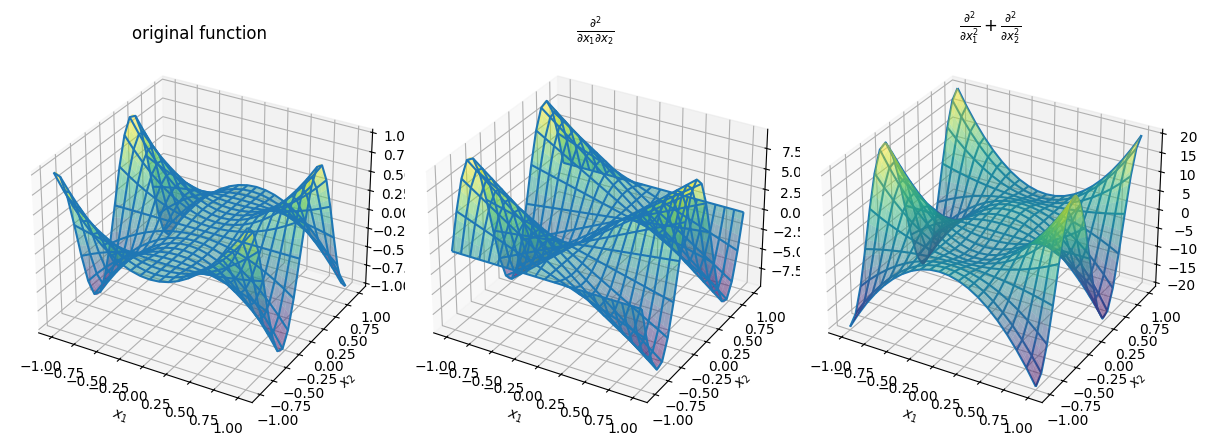

In [8]:
def plot_3d(F_n, L_n): # Put in a function, because I'll have to call this more than once.
	fig = pyplot.figure(figsize=(12, 5))
	ax1 = fig.add_subplot(1, 3, 1, projection='3d')
	ax1.plot_surface(X1, X2, y2, cmap='viridis', alpha=0.5)
	ax1.set_title('original function')
	ax1.set_xlabel(r'$x_1$')
	ax1.set_ylabel(r'$x_2$')
	ax2 = fig.add_subplot(1, 3, 2, projection='3d')
	ax2.plot_surface(X1, X2, dx1dx2y, cmap='viridis', alpha=0.5)
	ax2.set_title(r'$\frac{\partial^2}{\partial x_1 \partial x_2}$')
	ax2.set_xlabel(r'$x_1$')
	ax2.set_ylabel(r'$x_2$')
	ax3 = fig.add_subplot(1, 3, 3, projection='3d')
	ax3.plot_surface(X1, X2, Laplacian, cmap='viridis', alpha=0.5)
	ax3.set_title(r'$\frac{\partial^2}{\partial x_1^2} + \frac{\partial^2}{\partial x_2^2}$')
	ax3.set_xlabel(r'$x_1$')
	ax3.set_ylabel(r'$x_2$')

	ax1.plot_wireframe(X1_n, X2_n, y2_n)
	ax2.plot_wireframe(X1_n, X2_n, F_n)
	ax3.plot_wireframe(X1_n, X2_n, L_n)

	pyplot.tight_layout()

plot_3d(d2y_n, Laplacian_n)

All matches! Great!

## Simulating a PDE

Now let's do a full on simulation, following [Program 20 in Trefethen](https://epubs.siam.org/doi/epdf/10.1137/1.9780898719598.ch8), except in way fewer lines.

We have:

$$ u_{tt} = u_{xx} + u_{yy} \ , \ -1 \leq x, y \leq 1 \ , \ u = 0 \ \ \text{on the boundary}$$

with initial data

$$ u(x, y, 0) = e^{-40((x - 0.4)^2 + y^2)} \ , \ u_t(x, y, 0) = 0$$

  0%|          | 0/97 [00:00<?, ?it/s]

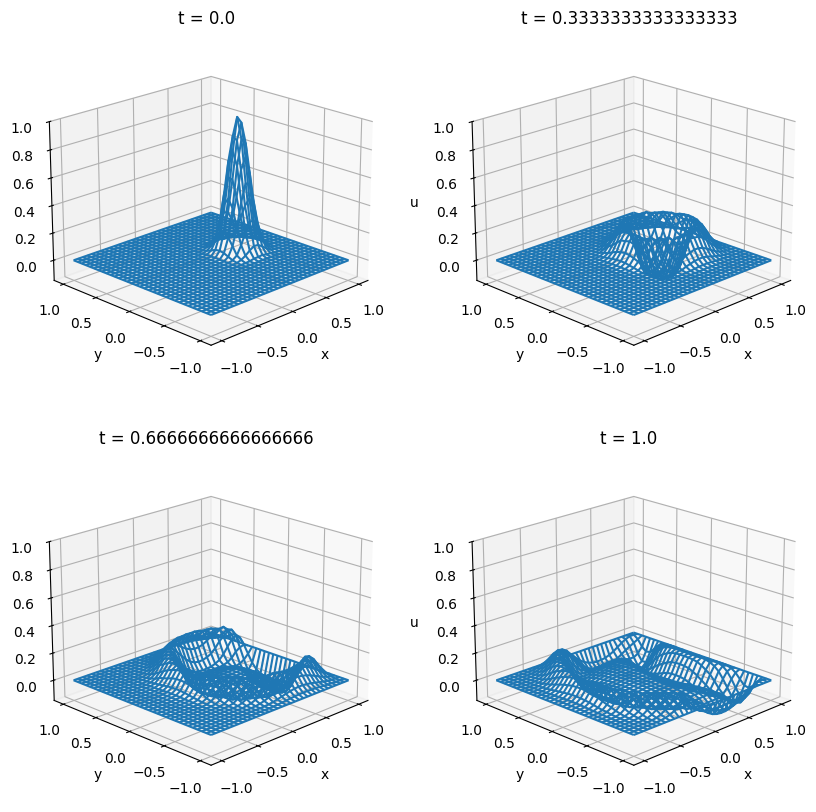

In [9]:
from scipy.interpolate import griddata
from tqdm.notebook import tqdm

N = 24
x_n = np.cos(np.linspace(0, N, N+1) * np.pi / N)
x_plot = np.arange(-1, 1 + 1/16, 1/16)

X_n, Y_n = np.meshgrid(x_n, x_n) # formerly xx and yy
X_plot, Y_plot = np.meshgrid(x_plot, x_plot)
points = np.stack([X_n.ravel(), Y_n.ravel()], -1) # shape (N, 2) in 2d, needed for griddata()

dt = 6/(N**2) # around the order of dt we want
plotgap = int((1/3)/dt) # plot every third of a second, which is this many dts

u = [np.exp(-40*((X_n - 0.4)**2 + Y_n**2))] # Keep all time slices for animation and leapfrog

fig = pyplot.figure(figsize=(10, 10))
for n in tqdm(range(0, 3*plotgap + 1)):
    t = n*dt
    if n % plotgap == 0: # plots at multiples of t=1/3
        ax = fig.add_subplot(2, 2, n//plotgap + 1, projection='3d')
        u_plot = griddata(points, u[-1].ravel(), (X_plot, Y_plot), method='cubic')
        ax.plot_wireframe(X_plot, Y_plot, u_plot)
        ax.set_zlim((-0.15, 1))
        ax.view_init(elev=20, azim=-135)
        ax.set_title('t = ' + str(t))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('u')
    
    rhs = legendre_deriv(u[-1], x_n, 2, axis=0) + legendre_deriv(u[-1], x_n, 2, axis=1) # righthand side of PDE
    rhs[:,0] = 0; rhs[:,-1] = 0; rhs[0, :] = 0; rhs[-1,:] = 0 # pin the boundary to 0 (hence no need to calculate endpoints above)

    if n == 0:
        u.append(u[-1] + (dt**2)*rhs) # on first iteration u_old is meant to be u, so 2u - 1u = 1u
    else:
        u.append(2*u[-1] - u[-2] + (dt**2)*rhs) # leapfrog update

### Saving as an Animation

To help diagnose exactly when and where the blowup originates, or to just see the simulation in its full glory, it's cool to render all plots as a video. To do this in `matplotlib` you have to use the `FuncAnimation` class, which I find a bit odd (Just let me append frames to a list and save from there.) but workable. 

In [10]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

stage, ax = pyplot.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
ax.view_init(elev=20, azim=-135)
def draw(n):
    u_plot = griddata(points, u[n].ravel(), (X_plot, Y_plot), method='cubic')
    ax.cla() # clear before next plot
    ax.set_title(f't = {n*dt:.3f}')
    ax.set_zlim((-0.15, 1))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.plot_wireframe(X_plot, Y_plot, u_plot)

animator = FuncAnimation(stage, draw, tqdm(range(len(u)))) # https://github.com/matplotlib/matplotlib/issues/29384
pyplot.close()
animator.save('wave_legendre.mp4', writer=FFMpegWriter(fps=10))

  0%|          | 0/98 [00:00<?, ?it/s]

Now let's see it!

In [11]:
from IPython.display import Video
Video("wave_legendre.mp4", embed=True)

If you're viewing this on GitHub, I didn't upload the video, so you'll have to run locally to see it. You'll need `ffmpeg` installed.